## Importing Modules

In [1]:
pip install emoji

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install wordcloud

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [4]:
pip install pycorenlp

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install dask

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
#%matplotlib notebook
from tqdm import tqdm
import dask.dataframe as dd
%matplotlib inline
#Module to handle regular expressions
import re
#manage files
import os
#Library for emoji
import emoji
#Import pandas and numpy to handle data
import pandas as pd
import numpy as np

In [7]:
#import libraries for accessing the database
import psycopg2
from sqlalchemy import create_engine
#from postgres_credentials import *

#import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image

In [8]:
#import libraries for tokenization and ML
import json
import tensorflow
import tensorflow.keras.preprocessing.text as kpt
#from keras.preprocessing.text import Tokenizer;
#Import nltk to check english lexicon
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import (
    wordnet,
    stopwords
)
import sklearn
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Import all libraries for creating a deep neural network
#Sequential is the standard type of neural network with stackable layers
from  tensorflow.keras.models import (
    Sequential,
    model_from_json
)
#Dense: Standard layers with every node connected, dropout: avoids overfitting
from  tensorflow.keras.layers import Dense, Dropout, Activation;

#To anotate database
from pycorenlp import StanfordCoreNLP

In [9]:
#Querying the database
def query_database():#tabletweets
    #engine = create_engine("postgresql+psycopg2://%s:%s@%s:%d/%s" %("postgres", 1234, "localhost", 5432, "postgres"))
    #table = pd.read_sql_query("select * from %s" %tabletweets,con=engine, index_col="id")
    table=pd.read_csv(r'full-corpus.csv')
    return table

In [10]:
table1=query_database()

In [11]:
table1.head(5)

,Topic,Sentiment,TweetId,TweetDate,Text
0,apple,positive,1.264160e+17,Tue Oct 18 21:53:25 +0000 2011,Now all @Apple has to do is get swype on the i...
1,apple,positive,1.264050e+17,Tue Oct 18 21:09:33 +0000 2011,@Apple will be adding more carrier support to ...
2,apple,positive,1.264030e+17,Tue Oct 18 21:02:20 +0000 2011,Hilarious @youtube video - guy does a duet wit...
3,apple,positive,1.263970e+17,Tue Oct 18 20:40:10 +0000 2011,@RIM you made it too easy for me to switch to ...
4,apple,positive,1.263960e+17,Tue Oct 18 20:34:00 +0000 2011,I just realized that the reason I got into twi...


## Preprocessing the text

Before we dig into analyzing the public opinion on 'Avengers', there is an important step that we need to take: preprocessing the tweet text. But what does this mean? Text preprocessing includes a basic text cleaning following a set of simple rules commonly used but also, advanced techniques that takes into account syntactic and lexical information.

In [12]:
#preprocess text in tweets by removing links, @UserNames, blank spaces, etc.
def preprocessing_text(table):
    #put everythin in lowercase
    table['Text'] = table['Text'].str.lower()
    #Replace rt indicating that was a retweet
    table['Text'] = table['Text'].str.replace('rt', '')
    #Replace occurences of mentioning @UserNames
    table['Text'] = table['Text'].replace(r'@\w+', '', regex=True)
    #Replace links contained in the tweet
    table['Text'] = table['Text'].replace(r'http\S+', '', regex=True)
    table['Text'] = table['Text'].replace(r'www.[^ ]+', '', regex=True)
    #remove numbers
    table['Text'] = table['Text'].replace(r'[0-9]+', '', regex=True)
    #replace special characters and puntuation marks
    table['Text'] = table['Text'].replace(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~]', '', regex=True)
    return table    

In [13]:
#Replace elongated words by identifying those repeated characters and then remove them and compare the new word with the english lexicon
def in_dict(word):
    if wordnet.synsets(word):
        #if the word is in the dictionary, we'll return True
        return True

def replace_elongated_word(word):
    regex = r'(\w*)(\w+)\2(\w*)'
    repl = r'\1\2\3'    
    if in_dict(word):
        return word
    new_word = re.sub(regex, repl, word)
    if new_word != word:
        return replace_elongated_word(new_word)
    else:
        return new_word

def detect_elongated_words(row):
    regexrep = r'(\w*)(\w+)(\2)(\w*)'
    row = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(row))
    words = [''.join(i) for i in re.findall(regexrep, row)]
    for word in words:
        if not in_dict(word): #below lines are from the internet
            row = re.sub(word, replace_elongated_word(word), row)
    return row 

In [14]:
def stop_words(table):
    #We need to remove the stop words
    stop_words_list = stopwords.words('english')
    table['Text'] = table['Text'].str.lower()
    table['Text'] = table['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_list)]))
    return table

In [15]:
def replace_antonyms(word):
    #We get all the lemma for the word
    for syn in wordnet.synsets(word): 
        for lemma in syn.lemmas(): 
            #if the lemma is an antonyms of the word
            if lemma.antonyms(): 
                #we return the antonym
                return lemma.antonyms()[0].name()
    return word
            
def handling_negation(row):
    #Tokenize the row
    words = word_tokenize(row)
    speach_tags = ['JJ', 'JJR', 'JJS', 'NN', 'VB', 'VBD', 'VBG', 'VBN', 'VBP']
    #We obtain the type of words that we have in the text, we use the pos_tag function
    tags = nltk.pos_tag(words)
    #Now we ask if we found a negation in the words
    tags_2 = ''
    if "n't" in words and "not" in words:
        tags_2 = tags[min(words.index("n't"), words.index("not")):]
        words_2 = words[min(words.index("n't"), words.index("not")):]
        words = words[:(min(words.index("n't"), words.index("not")))+1]
    elif "n't" in words:
        tags_2 = tags[words.index("n't"):]
        words_2 = words[words.index("n't"):] 
        words = words[:words.index("n't")+1]
    elif "not" in words:
        tags_2 = tags[words.index("not"):]
        words_2 = words[words.index("not"):]
        words = words[:words.index("not")+1] 
        
    for index, word_tag in enumerate(tags_2):
        if word_tag[1] in speach_tags:
            words = words+[replace_antonyms(word_tag[0])]+words_2[index+2:]
            break
            
    return ' '.join(words)    

In [16]:
def cleaning_table(table):
    #This function will process all the required cleaning for the text in our tweets
    table = preprocessing_text(table)
    table['Text'] = table['Text'].apply(lambda x: detect_elongated_words(x))
    table['Text'] = table['Text'].apply(lambda x: handling_negation(x))
    table = stop_words(table)
    return table

## Data Visualization

After we have cleaned our data but before we start building our model for sentiment analysis, we can perform an exploratory data analysis to see what are the most frequent words that appear in our 'Avengers' tweets. For this part, we will show graphs regarding tweets labelled as positive separated from those labelled as negative.

In [17]:
def vectorization(table):
    vector = CountVectorizer(stop_words='english')
    X = vector.fit_transform(table.Text)
    sum_frequencies = X.sum(axis=0)
    frequency = np.squeeze(np.asarray(sum_frequencies))
    
    # Use vectorizer.vocabulary_ to get feature names
    feature_names = list(vector.vocabulary_.keys())
    
    frequency_df = pd.DataFrame([frequency], columns=feature_names).transpose()
    return frequency_df

In [18]:
def word_cloud(tweets):
    
    #We get the directory that we are working on
    file = os.getcwd()
    #We read the mask image into a numpy array
    avengers_mask = np.array(Image.open(os.path.join(file, "avengers.png")))
    #Now we store the tweets into a series to be able to process 
    #tweets_list = pd.Series([t for t in tweet_table.tweet]).str.cat(sep=' ')  
    #We generate the wordcloud using the series created and the mask 
    word_cloud = WordCloud(width=2000, height=1000, max_font_size=200, background_color="black", max_words=2000, mask=avengers_mask, contour_width=1, 
                           contour_color="steelblue", colormap="nipy_spectral", stopwords=["avengers"])
    word_cloud.generate(tweets)
    
    #wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(tweets_list)
    
    #Now we plot both figures, the wordcloud and the mask
    #plt.figure(figsize=(15,15))
    plt.figure(figsize=(10,10))
    plt.imshow(word_cloud, interpolation="hermite")
    plt.axis("off")
    #plt.imshow(avengers_mask, cmap=plt.cm.gray, interpolation="bilinear")
    #plt.axis("off")    
    plt.show()  

In [19]:
def word_cloud(tweets):
    # You can remove the part related to loading the image mask
    # file = os.getcwd()
    # avengers_mask = np.array(Image.open(os.path.join(file, "avengers.png")))
    
    # Instead of using the mask, you can directly create the WordCloud object
    word_cloud = WordCloud(width=2000, height=1000, max_font_size=200, background_color="black", max_words=2000, colormap="nipy_spectral", stopwords=["avengers"])
    
    # Generate the word cloud
    word_cloud.generate(tweets)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 10))
    plt.imshow(word_cloud, interpolation="hermite")
    plt.axis("off")
    plt.show()

In [20]:
def graph(word_frequency, sent):
    labels = word_frequency[0][1:51].index
    title = "Word Frequency for %s" %sent
    #Plot the figures
    plt.figure(figsize=(10,5))
    plt.bar(np.arange(50), word_frequency[0][1:51], width = 0.8, color = sns.color_palette("bwr"), alpha=0.5, 
            edgecolor = "black", capsize=8, linewidth=1);
    plt.xticks(np.arange(50), labels, rotation=90, size=14);
    plt.xlabel("50 more frequent words", size=14);
    plt.ylabel("Frequency", size=14);
    #plt.title('Word Frequency for %s', size=18) %sent;
    plt.title(title, size=18)
    plt.grid(False);
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);
    plt.show() 

In [21]:
def regression_graph(table):
    table = table[1:]
    #We set the style of seaborn
    sns.set_style("whitegrid")   
    #Initialize the figure
    plt.figure(figsize=(6,6))
    
    #we obtain the points from matplotlib scatter
    points = plt.scatter(table["Positive"], table["Negative"], c=table["Positive"], s=75, cmap="bwr")
    #graph the colorbar
    plt.colorbar(points)
    #we graph the regplot from seaborn
    sns.regplot(x="Positive", y="Negative",fit_reg=False, scatter=False, color=".1", data=table)
    plt.xlabel("Frequency for Positive Tweets", size=14)
    plt.ylabel("Frequency for Negative Tweets", size=14)
    plt.title("Word frequency in Positive vs. Negative Tweets", size=14)
    plt.grid(False)
    sns.despine()

## Preparing data for model

After visualizing our data, the next step is to split our dataset into training and test sets. For doing so, we'll take advantage of the train_test_split functionality of sklearn package. We will take 20% of the dataset for testing following the 20–80% rule. From the remaining 80% used for the training set, we'll save a part for validation of our model.

In [22]:
#Split Data into training and test dataset
def splitting(table):
    X_train, X_test, y_train, y_test = train_test_split(table.Text, table.sentiment, test_size=0.2, shuffle=True)
    return X_train, X_test, y_train, y_test

In [23]:
#Tokenization for analysis
def tokenization_tweets(dataset, features):
    tokenization = TfidfVectorizer(max_features=features)
    tokenization.fit(dataset)
    dataset_transformed = tokenization.transform(dataset).toarray()
    return dataset_transformed

## Train model

In [24]:
#Create a Neural Network
#Create the model
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout

def train(X_train_mod, y_train, features, shuffle, drop, layer1, layer2, epoch, lr, epsilon, validation):
    model_nn = tf.keras.Sequential()
    model_nn.add(Dense(layer1, input_shape=(features,), activation='relu'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(layer2, activation='sigmoid'))
    model_nn.add(Dropout(drop))
    model_nn.add(Dense(3, activation='softmax'))
    
    # Define a learning rate schedule with decay
    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr,
        decay_steps=10000,  # Adjust this based on your data and preference
        decay_rate=0.9  # Adjust this based on your data and preference
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule, beta_1=0.9, beta_2=0.999, epsilon=epsilon, amsgrad=False)
    model_nn.compile(loss='sparse_categorical_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy'])
    
    model_nn.fit(np.array(X_train_mod), y_train,
                 batch_size=32,
                 epochs=epoch,
                 verbose=1,
                 validation_split=validation,
                 shuffle=shuffle)
    
    return model_nn

## Test model

In [25]:
def test(X_test, model_nn):
    prediction = model_nn.predict(X_test)
    return prediction

## Main code

In [26]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [27]:
if __name__ == "__main__":
    #tabletweets = "tweets_predict_avengers"
    tweet_table = query_database()#tabletweets
    tweet_table = cleaning_table(tweet_table)

# Sentiment Analysis

In [28]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [29]:
#tweets_final=tweets_final.drop([0], axis=1)
tweet_table['scores'] = tweet_table['Text'].apply(lambda review: sid.polarity_scores(review))
tweet_table.head(2)

,Topic,Sentiment,TweetId,TweetDate,Text,scores
0,apple,positive,1.264160e+17,Tue Oct 18 21:53:25 +0000 2011,get swype iphone crack iphone,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,apple,positive,1.264050e+17,Tue Oct 18 21:09:33 +0000 2011,adding carrier supo iphone announced,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [30]:
tweet_table['compound']  = tweet_table['scores'].apply(lambda score_dict: score_dict['compound'])
tweet_table.head(2)

,Topic,Sentiment,TweetId,TweetDate,Text,scores,compound
0,apple,positive,1.264160e+17,Tue Oct 18 21:53:25 +0000 2011,get swype iphone crack iphone,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0
1,apple,positive,1.264050e+17,Tue Oct 18 21:09:33 +0000 2011,adding carrier supo iphone announced,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0


In [31]:
tweet_table['sentiment'] = tweet_table['compound'].apply(lambda c: 'Positive' if c >=0 else 'Negative')
tweet_table.head(2)

,Topic,Sentiment,TweetId,TweetDate,Text,scores,compound,sentiment
0,apple,positive,1.264160e+17,Tue Oct 18 21:53:25 +0000 2011,get swype iphone crack iphone,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,Positive
1,apple,positive,1.264050e+17,Tue Oct 18 21:09:33 +0000 2011,adding carrier supo iphone announced,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,Positive


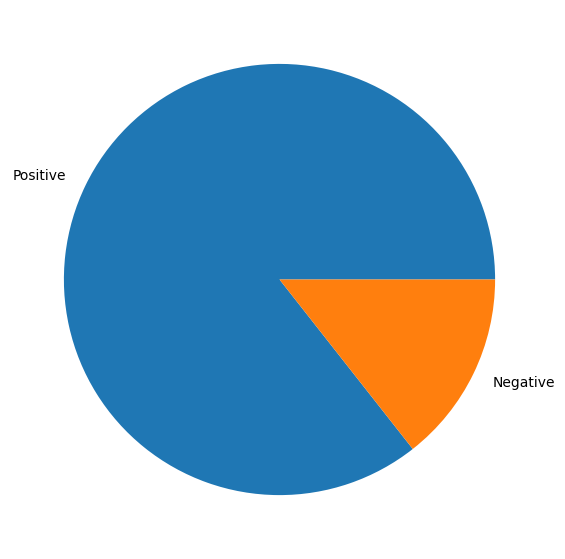

In [32]:
data = tweet_table['sentiment'].value_counts() 
labels=data.index
fig = plt.figure(figsize =(10, 7)) 
plt.pie(data, labels = labels) 

# show plot 
plt.show()

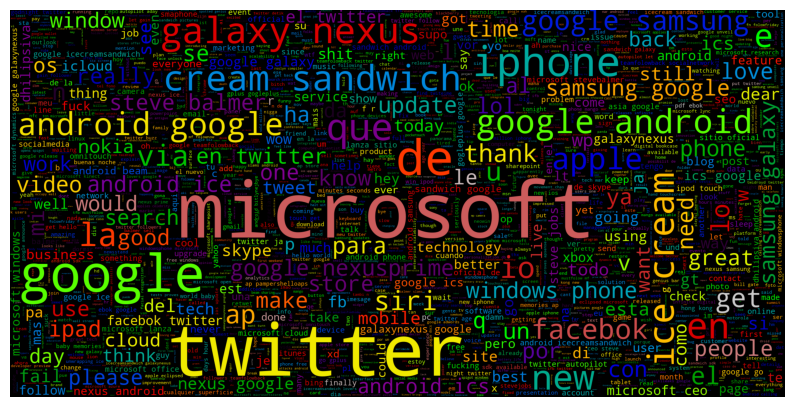

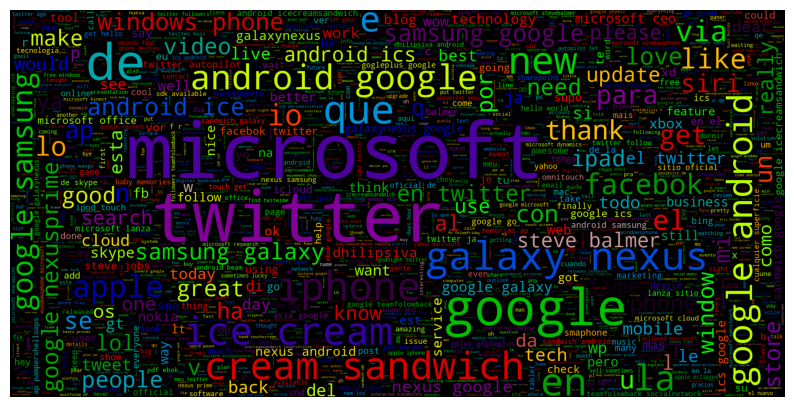

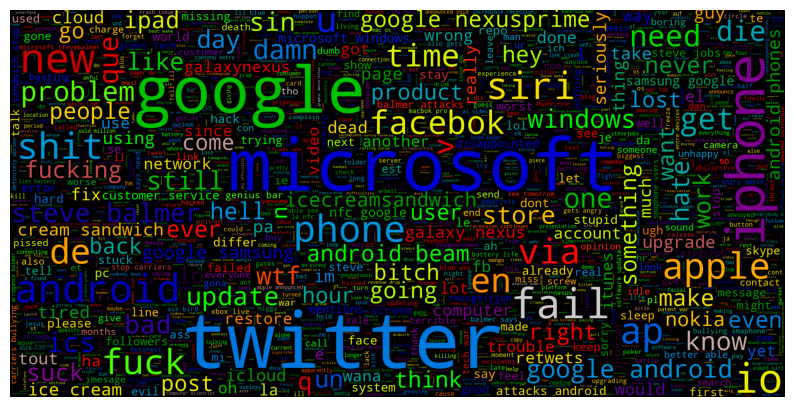

In [33]:
if __name__ == "__main__":
    # Assuming tweet_table is defined somewhere in your code
    all_tweets = pd.Series([t for t in tweet_table.Text]).str.cat(sep=' ')
    positive_tweets = pd.Series([t for t in tweet_table[tweet_table.sentiment == "Positive"].Text]).str.cat(sep=' ')
    negative_tweets = pd.Series([t for t in tweet_table[tweet_table.sentiment == "Negative"].Text]).str.cat(sep=' ')
    
    word_cloud(all_tweets)  # Word cloud for all tweets
    word_cloud(positive_tweets)  # Word cloud for positive sentiment tweets
    word_cloud(negative_tweets)  # Word cloud for negative sentiment tweets

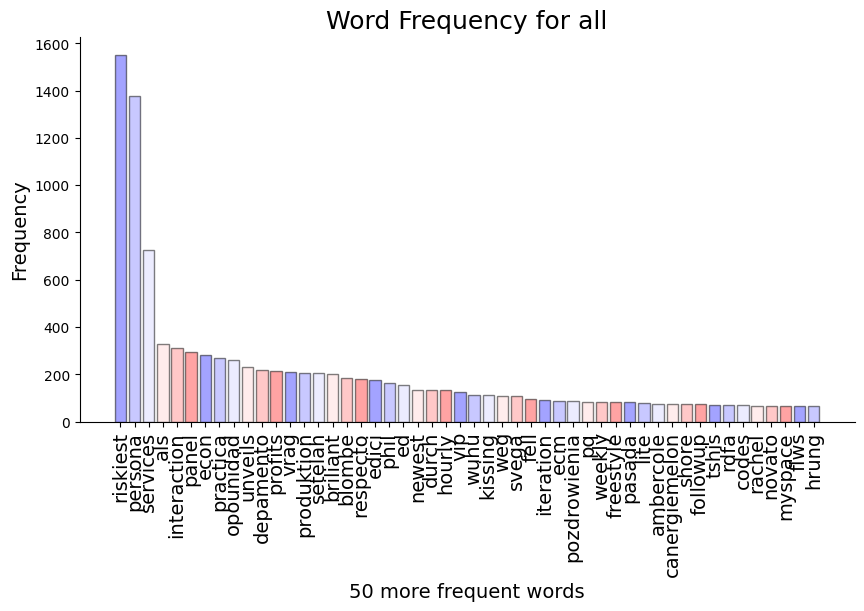

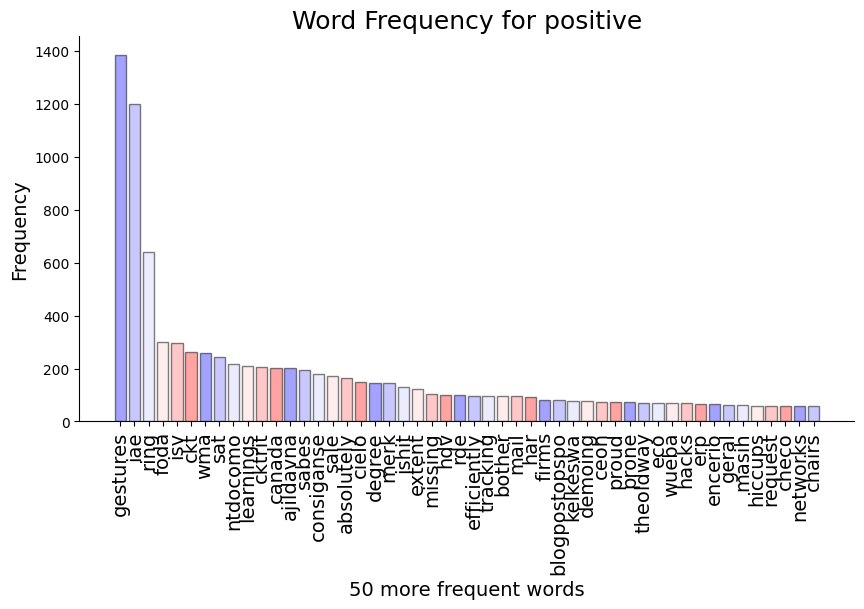

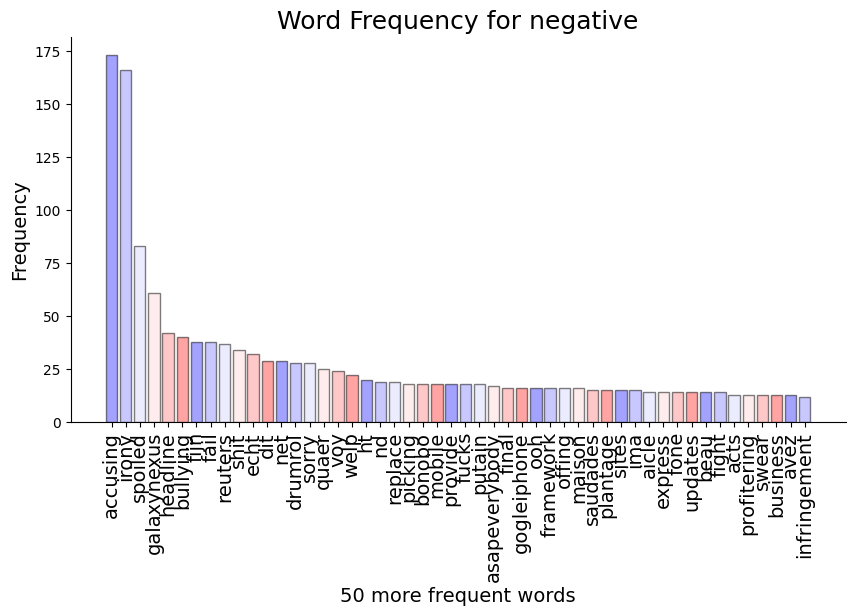

In [34]:
if __name__ == "__main__":
    #Get the frequency
    word_frequency = vectorization(tweet_table).sort_values(0, ascending=False)
    word_frequency_pos = vectorization(tweet_table[tweet_table['sentiment'] == 'Positive']).sort_values(0, ascending=False)
    word_frequency_neg = vectorization(tweet_table[tweet_table['sentiment'] == 'Negative']).sort_values(0, ascending=False)

    #Graph with frequency words all, positive and negative tweets and get the frequency
    graph(word_frequency, 'all')
    graph(word_frequency_pos, 'positive')
    graph(word_frequency_neg, 'negative')


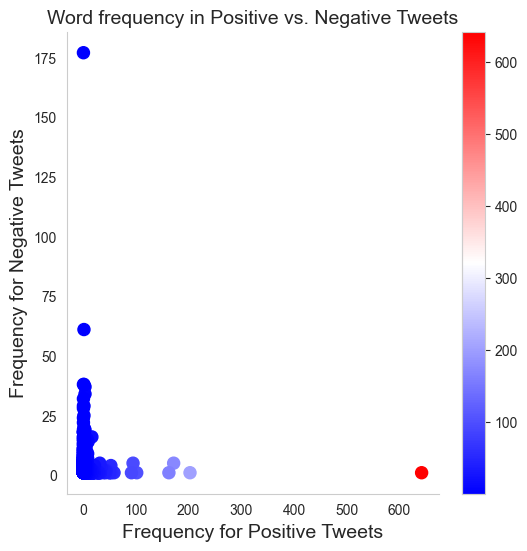

In [35]:
if __name__ == "__main__":
    #Concatenate word frequency for positive and negative
    table_regression = pd.concat([word_frequency_pos, word_frequency_neg], axis=1, sort=False)
    table_regression.columns = ["Positive", "Negative"]
    regression_graph(table_regression)

In [36]:
if __name__ == "__main__":
    tweet_table['sentiment'] = tweet_table['sentiment'].apply(lambda x: 2 if x == 'Positive' else (0 if x == 'Negative' else 1))

In [40]:
if __name__ == "__main__":
    X_train, X_test, y_train, y_test = splitting(tweet_table)

In [49]:
def model8(X_train, y_train):   
    features = 3500
    shufle = True
    drop = 0.5
    layer1 = 512
    layer2 = 256
    epoch = 5
    lr = 0.002
    epsilon = 1e-9
    validation = 0.1
    X_train_mod = tokenization_tweets(X_train, features)
    model = train(X_train_mod, y_train, features, shufle, drop, layer1, layer2, epoch, lr, epsilon, validation)
    return model

# Call the model8 function
trained_model = model8(X_train, y_train)


Epoch 1/5
116/116 [==============================] - 5s 36ms/step - loss: 0.4566 - accuracy: 0.8327 - val_loss: 0.3026 - val_accuracy: 0.8680
Epoch 2/5
116/116 [==============================] - 4s 33ms/step - loss: 0.2244 - accuracy: 0.9142 - val_loss: 0.2758 - val_accuracy: 0.8851
Epoch 3/5
116/116 [==============================] - 4s 33ms/step - loss: 0.1164 - accuracy: 0.9563 - val_loss: 0.3005 - val_accuracy: 0.8949
Epoch 4/5
116/116 [==============================] - 4s 33ms/step - loss: 0.0576 - accuracy: 0.9799 - val_loss: 0.3557 - val_accuracy: 0.8851
Epoch 5/5
116/116 [==============================] - 4s 36ms/step - loss: 0.0318 - accuracy: 0.9889 - val_loss: 0.3974 - val_accuracy: 0.8973


In [50]:
def save_model(model):
    model_json = model.to_json()
    with open('model.json', 'w') as json_file:
        json_file.write(model_json)

    model.save_weights('model8.h5')

model_final = model8(X_train, y_train)
save_model(model_final)

Epoch 1/5
116/116 [==============================] - 5s 36ms/step - loss: 0.5189 - accuracy: 0.8164 - val_loss: 0.3267 - val_accuracy: 0.8533
Epoch 2/5
116/116 [==============================] - 4s 34ms/step - loss: 0.2401 - accuracy: 0.9008 - val_loss: 0.2925 - val_accuracy: 0.8900
Epoch 3/5
116/116 [==============================] - 4s 34ms/step - loss: 0.1324 - accuracy: 0.9481 - val_loss: 0.2989 - val_accuracy: 0.8924
Epoch 4/5
116/116 [==============================] - 4s 34ms/step - loss: 0.0771 - accuracy: 0.9726 - val_loss: 0.3428 - val_accuracy: 0.8826
Epoch 5/5
116/116 [==============================] - 4s 35ms/step - loss: 0.0399 - accuracy: 0.9864 - val_loss: 0.3804 - val_accuracy: 0.8900


In [51]:
if __name__ == "__main__":
    X_new = tokenization_tweets(tweet_table.Text, 3500)
    new_prediction = model_final.predict(X_new)

160/160 [==============================] - 1s 6ms/step


In [52]:
if __name__ == "__main__":
    labels = ['Negative', 'Neutral', 'Positive']
    sentiments = [labels[np.argmax(pred)] for pred in new_prediction]
    tweet_table["sentiment"] = sentiments

In [53]:
print(tweet_table.Text)

0                           get swype iphone crack iphone
1                    adding carrier supo iphone announced
2       hilarious video guy duet siri pretty much sums...
3                          made easy switch iphone see ya
4                  realized reason got twitter ios thanks
                              ...                        
5108                                      cop con twitter
5109               buenas noches gente twitter los quiero
5110    twitter tiene la mala costumbre de ponerce bno...
5111    oi muito bem vinda ao meu twitter sempre dou f...
5112    eles arastaram os barcos para praia deixaram t...
Name: Text, Length: 5113, dtype: object


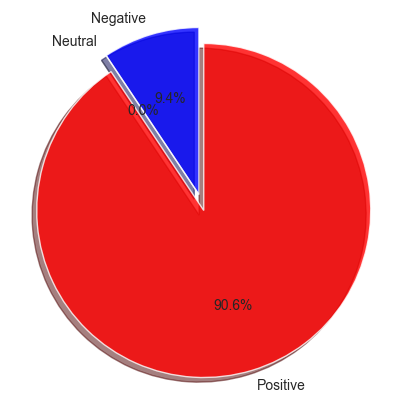

In [54]:
sizes = [sentiments.count('Negative'), sentiments.count('Neutral'), sentiments.count('Positive')]
explode = (0, 0, 0.1)
labels = 'Negative', 'Neutral', 'Positive'
plt.figure(figsize=(5,5))
plt.pie(sizes, explode=explode, colors="bwr", labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, wedgeprops={'alpha':0.8})
plt.axis('equal') 
plt.show()

### Extra analysis for interaction network

In [55]:
if __name__ == "__main__":
    tweet_table_interaction = pd.read_csv("full-corpus.csv")
#     print(tweet_table_interaction)
    tweet_table_interaction.rename(columns = {"Text": "Text"}, inplace=True)
    tweet_table_interaction = cleaning_table(tweet_table_interaction) 
    X_interaction = tokenization_tweets(tweet_table_interaction.Text, 3500)

In [56]:
if __name__ == "__main__":
    # Open json file of saved model
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    # Create a model 
    model = model_from_json(loaded_model_json)
    # Weight nodes with saved values
    model.load_weights('model8.h5')

In [57]:
if __name__ == "__main__":
    int_prediction = model.predict(X_interaction)
    labels = ['Negative', 'Neutral', 'Positive']
    sentimentss = [labels[np.argmax(pred)] for pred in int_prediction]
    tweet_table_interaction["sentiment"] = sentiments

160/160 [==============================] - 1s 6ms/step


In [58]:
tweet_table_interaction.to_csv("tweets_final_sentiment.csv")

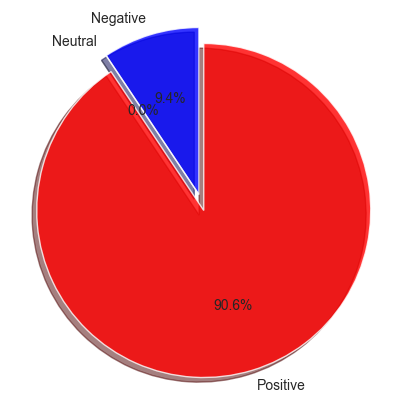

In [59]:
sizes = [sentimentss.count('Negative'), sentimentss.count('Neutral'), sentimentss.count('Positive')]
explode = (0, 0, 0.1)
labels = 'Negative', 'Neutral', 'Positive'
plt.figure(figsize=(5,5))
plt.pie(sizes, explode=explode, colors="bwr", labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, wedgeprops={'alpha':0.8})
plt.axis('equal') 
plt.show()